In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader  # Fixed typo here
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
class CustomCNN(nn.Module):
    def __init__(self): # The __init__ method is used for initializing the attributes (variables) of the object when the object is created.
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)  # Output: 28x28x3
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)  # Output: 28x28x5
        self.pool1 = nn.MaxPool2d(2, 2)                        # Output: 14x14x5
        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)  # Output: 14x14x5
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)  # Output: 14x14x3
        self.pool2 = nn.MaxPool2d(2, 2)                        # Output: 7x7x3

        # Fully connected layers
        self.fc1 = nn.Linear(7 * 7 * 3, 147)                  # Output: 147x1
        self.fc2 = nn.Linear(147, 10)                         # Output: 10x1

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout for convolutional layers
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout for fully connected layers

        # Batch normalization for fully connected layers
        self.batch_norm1 = nn.BatchNorm1d(147)
        self.batch_norm2 = nn.BatchNorm1d(10)

        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))      # 28x28x3
        x = self.relu(self.conv2(x))      # 28x28x5
        x = self.pool1(x)                 # 14x14x5
        x = self.relu(self.conv3(x))      # 14x14x5
        x = self.relu(self.conv4(x))      # 14x14x3
        x = self.pool2(x)                 # 7x7x3

        x = self.dropout1(x)              # Dropout for convolutional output
        x = x.view(-1, 7 * 7 * 3)         # Flatten to 147x1

        # Fully connected layers with batch normalization, dropout, and sigmoid activation
        x = self.batch_norm1(x)  # Batch normalization first
        x = self.dropout2(x)
        x = self.sigmoid(x)      # Dropout for fully connected layers
        x = self.fc2(x)          # Fully connected layer
        x = self.batch_norm2(x)  # Batch normalization
            

        return x


In [32]:
from torch.utils.data import DataLoader, random_split

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion MNIST dataset
full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Calculate the sizes for training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

# Load the test dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000


In [33]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. Device count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f" - Memory allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f" - Memory cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available. Device count: 1
Device 0: NVIDIA GeForce RTX 2060
 - Memory allocated: 0.02 GB
 - Memory cached: 0.10 GB


In [34]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


cuda


In [35]:
from tqdm import tqdm  # Import tqdm for the progress bar

# Training and validation loop
epochs = 15
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc="Training", unit="batch")
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()          # Reset gradients
        outputs = model(images)       # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()               # Backward pass
        optimizer.step()              # Update weights
        running_loss += loss.item()   # Accumulate loss
        train_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar with current loss

    # Calculate average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    valid_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", unit="batch")  # Use val_loader instead of test_loader
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)       # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            valid_loss += loss.item()     # Accumulate loss
            val_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar with current loss
    
    # Calculate average validation loss
    valid_loss /= len(val_loader)
    valid_losses.append(valid_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


Epoch 1/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.31batch/s, loss=1.57]


Epoch 1, Training Loss: 2.0486, Validation Loss: 1.5681
Epoch 2/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.14batch/s, loss=1.23]


Epoch 2, Training Loss: 1.4540, Validation Loss: 1.2222
Epoch 3/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.42batch/s, loss=1.07]


Epoch 3, Training Loss: 1.2966, Validation Loss: 1.0780
Epoch 4/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.32batch/s, loss=0.934]


Epoch 4, Training Loss: 1.1627, Validation Loss: 0.9514
Epoch 5/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.36batch/s, loss=0.823]


Epoch 5, Training Loss: 1.0417, Validation Loss: 0.8443
Epoch 6/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.40batch/s, loss=0.748]


Epoch 6, Training Loss: 0.9469, Validation Loss: 0.7713
Epoch 7/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.45batch/s, loss=0.695]


Epoch 7, Training Loss: 0.8868, Validation Loss: 0.7218
Epoch 8/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.56batch/s, loss=0.654]


Epoch 8, Training Loss: 0.8408, Validation Loss: 0.6857
Epoch 9/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.52batch/s, loss=0.631]


Epoch 9, Training Loss: 0.8114, Validation Loss: 0.6611
Epoch 10/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.56batch/s, loss=0.601]


Epoch 10, Training Loss: 0.7840, Validation Loss: 0.6330
Epoch 11/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.54batch/s, loss=0.586]


Epoch 11, Training Loss: 0.7612, Validation Loss: 0.6174
Epoch 12/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.57batch/s, loss=0.573]


Epoch 12, Training Loss: 0.7441, Validation Loss: 0.6035
Epoch 13/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.53batch/s, loss=0.561]


Epoch 13, Training Loss: 0.7276, Validation Loss: 0.5890
Epoch 14/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.53batch/s, loss=0.556]


Epoch 14, Training Loss: 0.7106, Validation Loss: 0.5781
Epoch 15/15


Validation: 100%|██████████| 12/12 [00:02<00:00,  5.60batch/s, loss=0.533]

Epoch 15, Training Loss: 0.6931, Validation Loss: 0.5616


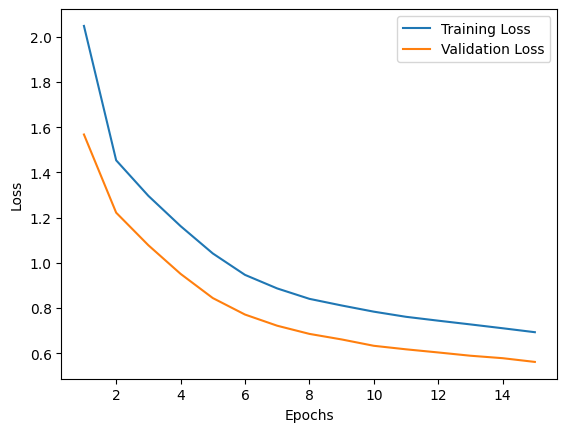

In [36]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing the model and generating confusion matrix and F1 scores
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Confusion Matrix:
 [[802   2  23  90   7   3  60   0  13   0]
 [  0 950   3  36   2   0   7   0   2   0]
 [ 11   1 663  12 213   1  97   0   2   0]
 [ 23  17   4 865  44   1  45   0   1   0]
 [  0   3  93  50 786   0  64   0   4   0]
 [  0   0   0   0   0 954   1  27   2  16]
 [236   0 147  69 197   0 326   0  25   0]
 [  0   0   0   0   0  29   0 897   1  73]
 [  0   3   2  12   5   4  12   4 957   1]
 [  0   0   0   2   0  15   0  38   2 943]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77      1000
           1       0.97      0.95      0.96      1000
           2       0.71      0.66      0.69      1000
           3       0.76      0.86      0.81      1000
           4       0.63      0.79      0.70      1000
           5       0.95      0.95      0.95      1000
           6       0.53      0.33      0.40      1000
           7       0.93      0.90      0.91      1000
           8       0.95      0.96      

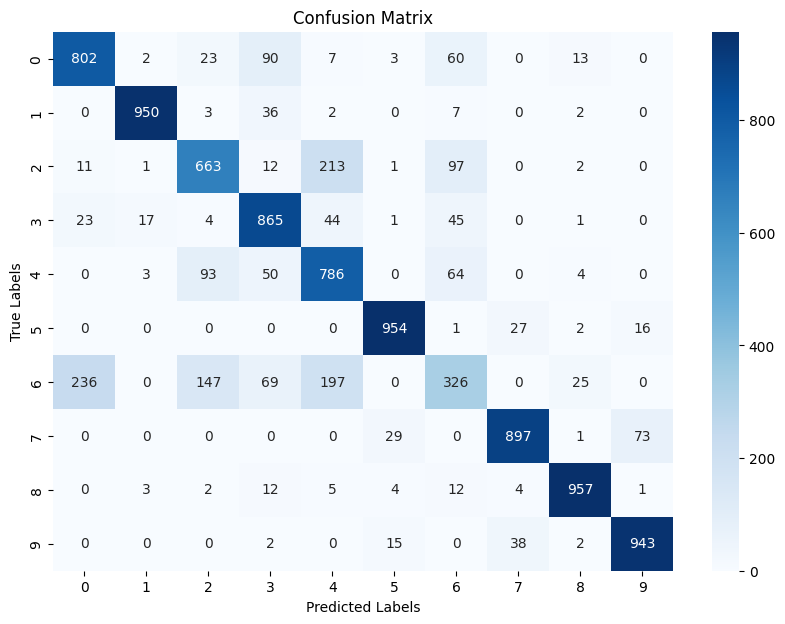

In [37]:
# Generate confusion matrix and F1 scores
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(all_labels, all_preds))

# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()